<a href="https://colab.research.google.com/github/BanyanLiu/titanic-analysis2/blob/main/%E5%B0%88%E9%A1%8C%E5%AF%A6%E4%BD%9C_%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F%E5%AD%98%E6%B4%BB%E9%A0%90%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
# 和是否生還相關性高的欄位
x = data.drop(["Name","Ticket","Cabin","Embarked","Survived","Age"], axis=1)
x["Sex"],_ = x["Sex"].factorize() # 把姓別從類別資料轉為數值資料
y = data[["Survived"]]

#計算每一欄有多少缺失值
per_col_missing = x.isnull().sum()
total_missing = per_col_missing.sum()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<BarContainer object of 6 artists>

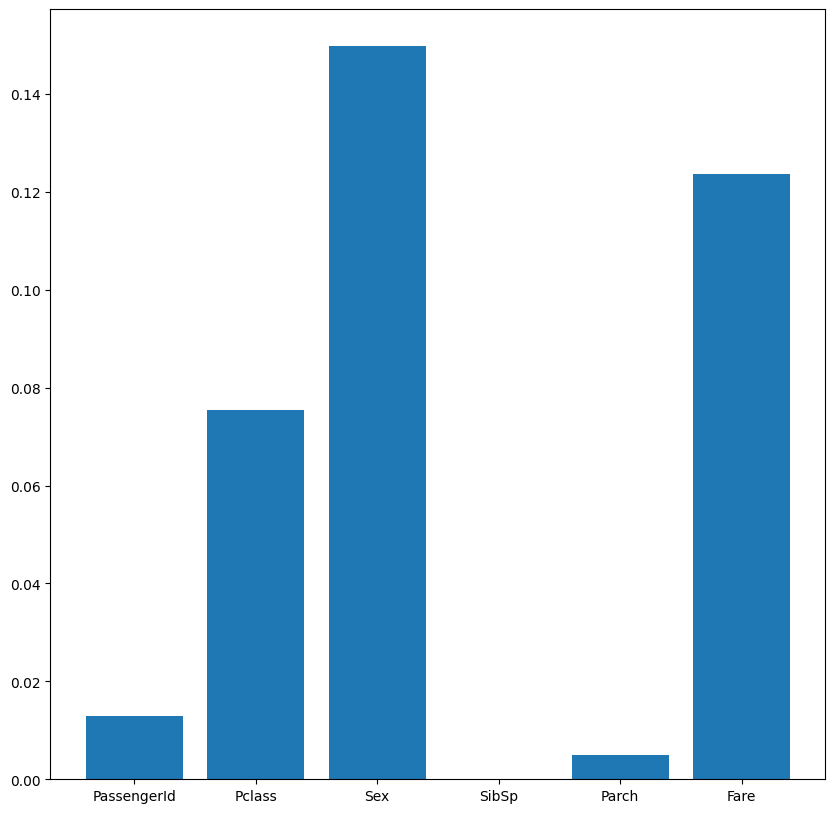

In [4]:
# 計算mutual information
select = mutual_info_regression(x,y)
select = pd.DataFrame(select,index = x.columns, columns = ["MI"])
select["MI"].sort_values(ascending = True)

#把計算出來的mutual information畫出來
figure, axes = plt.subplots(figsize = (10,10))
axes.bar(select.index,select["MI"])

<ipython-input-5-bcfb4bf7190c>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  only_survive = data.dropna()[data["Survived"]==1]


<BarContainer object of 51 artists>

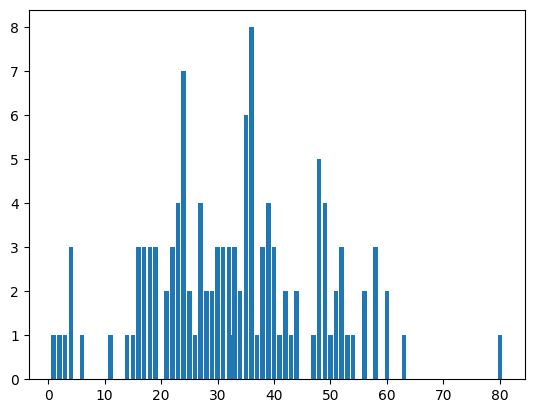

In [5]:
#畫age和survive的關係圖
only_survive = data.dropna()[data["Survived"]==1]
only_survive_s = only_survive.groupby("Age", as_index=False)["Survived"].value_counts()
only_survive_s = pd.DataFrame(only_survive_s)
plt.bar(only_survive_s["Age"], only_survive_s["count"])
#在groupby的指令中加入as_index，是為了指定是否讓分組欄位當作索引值，False表示會不會讓分組欄位當作索引值
#和是否存活這個變數相關性高的參數有Pclass, sex, Parch, Fare
#而從圖中可以看到主要的存活人數落在20到30以及30到40區間

<Axes: xlabel='Survived', ylabel='count'>

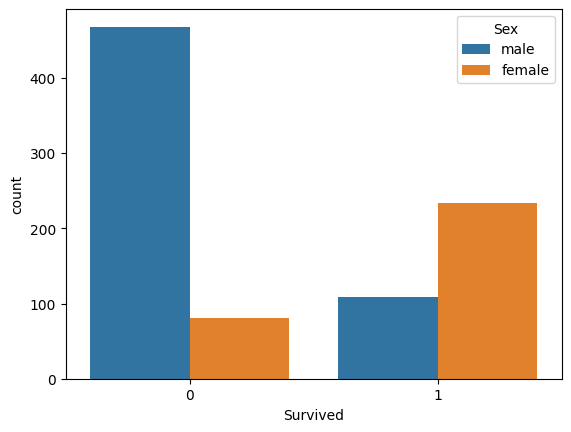

In [6]:
#畫出不同性別和是否會影響存活，不同姓別的存活個數
sns.countplot(x=data["Survived"], hue=data["Sex"], data = data)
#可以看出男性死亡的比例高於女性

<Axes: xlabel='Survived', ylabel='count'>

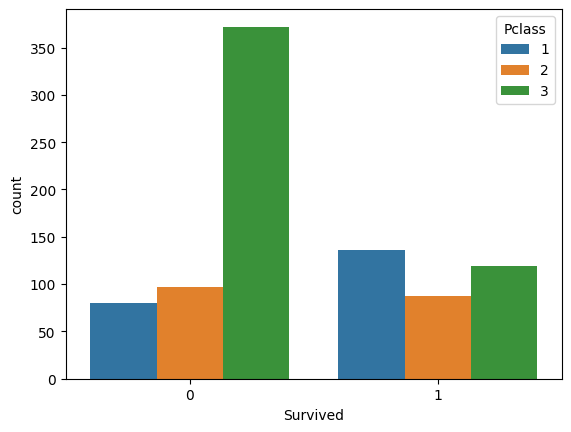

In [14]:
#看不同的艙等是否會影響存活，不同艙等的存活個數
sns.countplot(x=data["Survived"], hue=data["Pclass"], data = data)
#可以看出艙等比較低的存活率較低

<Axes: xlabel='Pclass', ylabel='Age'>

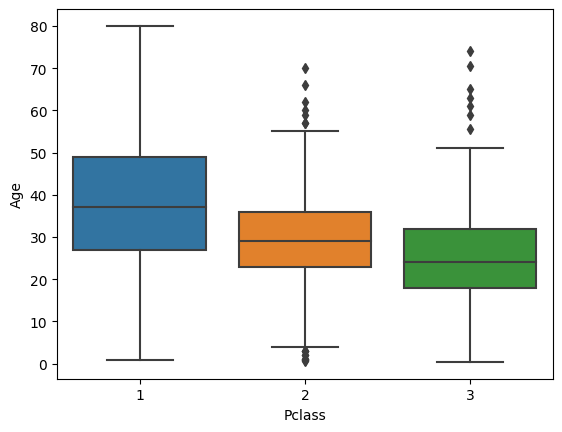

In [12]:
#從前面的程式可以得知Age的缺失值最多，要對它進行補值
sns.boxplot(x=data["Pclass"],y=data["Age"], data = data)

#艙等比較高的年紀較大，所以要對年紀補值要判斷缺失值是屬於哪個艙等

In [42]:
#對年紀補值依照艙等
data["Age"] = data.groupby("Pclass")["Age"].transform('mean')

In [52]:
# 建立baseline model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
trainx = data.drop("Survived", axis=1)
trainy = data[["Survived"]]
log1 = LogisticRegression(random_state=0, max_iter=3000)
scores = cross_val_score(log1,x,y.values.ravel(),cv=5,scoring='accuracy')
print(scores)

[0.81005587 0.80337079 0.78089888 0.76966292 0.80898876]


In [84]:
# 建立第二種版本的模型

#進行特徵工程
newx = pd.concat([x,data["Age"]], axis=1).drop(["PassengerId","SibSp","Parch"],axis=1)

#切分訓練集、測試集
X_train, X_test, y_train, y_test = train_test_split(newx,y,test_size=0.3,random_state=42)

#丟進去logistic regression
log2 = LogisticRegression(random_state = 42)
model2 = log2.fit(X_train,y_train)
predict2 = model2.predict(X_test)
predict2 = predict2.reshape(-1,1)

#算正確程度
error_index=np.where(predict2 != y_test.values)[0]
print('test accuracy:',1-len(error_index)/len(X_test))

test accuracy: 0.791044776119403


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
